In [158]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
 
 #From updated functions.py from Canvas. Changed names on functions from previous version.
 
def softmax(x):
    """ Standard definition of the softmax function """
    return np.exp(x) / np.sum(np.exp(x), axis=0)


def LoadBatch(filename):
    """ Copied from the dataset website """
    with open('Datasets/' + filename, 'rb') as fo:
        dataset_dict = pickle.load(fo, encoding='bytes')
 
    return dataset_dict
 
 
def montage(W):
    """ Display the image for each label in W """
    fig, ax = plt.subplots(2, 5)
    for i in range(2):
        for j in range(5):
            im = W[i * 5 + j, :].reshape(32, 32, 3, order='F')
            sim = (im - np.min(im[:])) / (np.max(im[:]) - np.min(im[:]))
            sim = sim.transpose(1, 0, 2)
            ax[i][j].imshow(sim, interpolation='nearest')
            ax[i][j].set_title("y=" + str(5 * i + j))
            ax[i][j].axis('off')
    plt.show()
 
 
def save_as_mat(data, name="model"):
    """ Used to transfer a python model to matlab """
    import scipy.io as sio
    sio.savemat(f'{name}.mat', {"name": "b"})


def load(filename):
    data = LoadBatch(filename)
    
    X = data[b'data'].astype(np.float32).reshape(-1, 3072).T / 255
    y = np.array(data[b'labels']).astype(np.int32)
    
    Y = np.zeros((10, y.shape[0]), dtype=np.float32)
    for i, label in enumerate(y):
        Y[label, i] = 1
    
    return X, Y, y + 1


def initialize_weights(shapes_list):
    np.random.seed(369)

    weights = []
    biases = []

    for shape in shapes_list:
        W = np.random.normal(0, 0.001, size=(shape[0], shape[1]))
        b = np.zeros(shape=(shape[0], 1))

        weights.append(W)
        biases.append(b)

    return weights, biases



def normalize_data(train, validation, test):
    # Compute the mean and standard deviation of the training data
    train_mean = np.mean(train, axis=1, keepdims=True)
    train_std = np.std(train, axis=1, keepdims=True)

    # Normalize the training, validation and test data
    train_norm = (train - train_mean) / train_std
    validation_norm = (validation - train_mean) / train_std
    test_norm = (test - train_mean) / train_std

    return train_norm, validation_norm, test_norm


In [182]:
def he_initialization_k_layers(shapes_list):
    """
    He initialization on the weight matrices.

    :param shapes_list: List that contains the dimensions of each layer of the network.

    :return: Initialized weight and bias matrices based on He initialization of the weights.
    """

    weights = []
    biases = []

    for pair in shapes_list:

        weights.append(np.random.randn(pair[0], pair[1]) * np.sqrt(2 / float(pair[0])))
        biases.append(np.zeros(shape=(pair[0], 1)))

    return weights, biases

In [188]:
"""def ComputeCost(X, Y, W, b, lambda_):
    P, _ = forward_pass(X, W, b)
    l_cross = -np.log(np.diag(np.dot(Y.T, P)))
    l_cross = np.sum(l_cross) / X.shape[1]
    l2 = 0
    for w in W:
        l2 += np.sum(w**2)
    l2 *= lambda_
    cost = l_cross + l2
    return cost, l_cross"""

def compute_loss(Y, P, num_samples):
    return -np.sum(Y * np.log(P)) / num_samples

def compute_regularization(lamda, W):
    return sum([lamda * np.sum(W_l ** 2) for W_l in W])

def ComputeCost(X, Y, W, b, lamda):

    P, _ = forward_pass(X, W, b)

    loss = compute_loss(Y, P, X.shape[1])
    reg = compute_regularization(lamda, W)
    cost = loss + reg

    return cost, loss


def softmax(x):
    """ Standard definition of the softmax function """
    return np.exp(x) / np.sum(np.exp(x), axis=0)

"""def softmax(X, theta=1.0, axis=None):

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis=axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis=axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1:
        p = p.flatten()

    return p
def forward_pass(X, W, b):


    outputs = []
    activations = []

    s = np.dot(W[0], X) + b[0]
    outputs.append(s)
    H = np.maximum(0, s)
    activations.append(H)

    for i in range(1, len(W)-1):
        s = np.dot(W[i], activations[-1]) + b[i]
        outputs.append(s)
        H = np.maximum(0, s)
        activations.append(H)
    
    s = np.dot(W[-1], activations[-1]) + b[-1]
    P = softmax(s)
    

    return P, activations, outputs"""

def relu(S):
    H = S
    H[H<0] = 0
    return H

def forward_pass(X, W, b):
    num_layers = len(W)
    X_layer =[X.copy()]+[None]*(num_layers-1)
    S = [None]*(num_layers-1)

    for layer in range(num_layers-1):
        S[layer] = np.dot(W[layer], X_layer[layer]) + b[layer]
        X_layer[layer+1] = relu(S[layer])
            
    P = softmax(np.matmul(W[num_layers-1], X_layer[num_layers-1]) + b[num_layers-1])

    return P, X_layer

In [160]:
def ComputeAccuracy(X, y, W, b):
    """ Function that computes the accuracy of network predictions """
    P, _ = forward_pass(X, W, b)
    predictions = np.argmax(P, axis=0)
    accuracy = np.sum(predictions == y) / X.shape[1]
    return accuracy

In [161]:
def ComputeGradients(X, Y, W, b, lambda_):
    """ Function that computes the gradients of the cost function """
    num_layers = len(W)
    
    # initialize gradients
    grad_W = [None] * num_layers
    grad_b = [None] * num_layers
    P, X_layer = forward_pass(X, W, b)
    G = P - Y

    grad_W[num_layers-1] = np.matmul(G, X_layer[num_layers-1].T) / X.shape[1] + 2 * lambda_ * W[num_layers-1]
    grad_b[num_layers-1] = np.matmul(G, np.ones((X.shape[1], 1))) / X.shape[1]
    for layer in range(num_layers-2, -1, -1):
        G = np.matmul(W[layer+1].T, G) * (X_layer[layer+1] > 0)
        grad_W[layer] = np.matmul(G, X_layer[layer].T) / X.shape[1] + 2 * lambda_ * W[layer]
        grad_b[layer] = np.matmul(G, np.ones((X.shape[1], 1))) / X.shape[1]

    return grad_W, grad_b



In [162]:

def compute_gradients_num(X,Y, W, b, lambda_, h):
    grad_weights = []
    grad_bias = []

    for layer in range(len(W)):
        weights = W[layer]
        bias = b[layer]

        grad_W = np.zeros(weights.shape)
        grad_b = np.zeros(bias.shape)


        #W
        for i in tqdm(range(0, weights.shape[0])):
            for j in range(weights.shape[1]):
                W_ = np.copy(weights)
                W_[i,j] -= h
                temp_weights= W.copy()
                temp_weights[layer] = W_
                c1, _ = ComputeCost(X, Y, temp_weights, b, lambda_)
                W_ = np.copy(weights)
                W_[i,j] += h
                temp_weights= W.copy()
                temp_weights[layer] = W_
                c2, _= ComputeCost(X, Y, temp_weights, b, lambda_)
                grad_W[i,j] = (c2 - c1) / (2*h)
        
        grad_weights.append(grad_W)

        for i in tqdm(range(bias.shape[0])):
            b_ = np.copy(bias)
            b_[i, 0] -= h
            temp_bias = b.copy()
            temp_bias[layer] = b_
            c1, _ = ComputeCost(X, Y, W, temp_bias, lambda_)
                
            b_ = np.copy(bias)
            b_[i, 0] += h
            temp_bias = b.copy()
            temp_bias[layer] = b_
            c2 = ComputeCost(X, Y, W, temp_bias, lambda_)[0]
            grad_b[i, 0] = (c2 - c1) / (2*h)

        grad_bias.append(grad_b)

    return grad_weights, grad_bias

In [163]:
def ComputeTestingGradient(grad_weights, grad_biases, num_weights, num_biases):
    for layer in range(len(grad_weights)):
        grad_w = grad_weights[layer]
        grad_b = grad_biases[layer]
        num_w = num_weights[layer]
        num_b = num_biases[layer]
        print(f'Layer {layer}')
        print(f'Weight difference: {np.max(np.abs(grad_w - num_w))}')
        print(f'Bias difference: {np.max(np.abs(grad_b - num_b))}')

In [164]:
W, b = initialize_weights([(50, 3072), (10, 50)])


X_train, Y_train, y_train = load('data_batch_1')
X_validation, Y_validation, y_validation = load('data_batch_2')
X_test, Y_test, y_test = load('test_batch')

X_train, X_validation, X_test = normalize_data(X_train, X_validation, X_test)

lambda_ = 0

grad_weights, grad_biases = ComputeGradients(X_train[:, :100], Y_train[:, :100], W, b, lambda_)

grad_weights_num, grad_biases_num = compute_gradients_num(X_train[:, :100], Y_train[:, :100], W, b, lambda_, 1e-5)

ComputeTestingGradient(grad_weights, grad_biases, grad_weights_num, grad_biases_num)



100%|██████████| 10/10 [00:00<00:00, 257.46it/s]

Layer 0
Weight difference: 5.2712595143344104e-06
Bias difference: 4.743405346178179e-07
Layer 1
Weight difference: 5.581195488407742e-11
Bias difference: 4.614773493893942e-11


In [166]:
# initalize for layer 3
W, b = initialize_weights([(50, 3072), (20, 50), (10, 20)])

grad_weights, grad_biases = ComputeGradients(X_train[:, :100], Y_train[:, :100], W, b, lambda_)
grad_weights_num, grad_biases_num = compute_gradients_num(X_train[:, :100], Y_train[:, :100], W, b, lambda_, 1e-5)

ComputeTestingGradient(grad_weights, grad_biases, grad_weights_num, grad_biases_num)


100%|██████████| 10/10 [00:00<00:00, 291.51it/s]

Layer 0
Weight difference: 2.9775476790826163e-08
Bias difference: 2.538692039383897e-09
Layer 1
Weight difference: 5.459380299068359e-07
Bias difference: 8.944099333349232e-06
Layer 2
Weight difference: 3.9398385192447117e-11
Bias difference: 5.818792843392817e-11


In [ ]:
# initalise for layer 4

W, b = initialize_weights([(50, 3072), (20, 50), (15, 20), (10, 15)])

grad_weights, grad_biases = ComputeGradients(X_train[:, :100], Y_train[:, :100], W, b, lambda_)
grad_weights_num, grad_biases_num = compute_gradients_num(X_train[:, :100], Y_train[:, :100], W, b, lambda_, 1e-5)

ComputeTestingGradient(grad_weights, grad_biases, grad_weights_num, grad_biases_num)


100%|██████████| 10/10 [00:00<00:00, 343.89it/s]

Layer 0
Weight difference: 9.552803442328111e-11
Bias difference: 5.132965439285484e-11
Layer 1
Weight difference: 1.005978001094028e-09
Bias difference: 1.8794302813230205e-08
Layer 2
Weight difference: 3.458419206927279e-09
Bias difference: 0.00010009308286438206
Layer 3
Weight difference: 4.453819918062164e-11
Bias difference: 3.4199748935592744e-11


In [178]:

def train_network_cyclical(X_train, Y_train, X_val, Y_val, weights, biases, lambda_, n_batch, eta_min, eta_max, n_s, n_epochs, y_train, y_val, X_test, y_test):
    train_losses = []
    val_losses = []
    train_costs = []
    val_costs = []

    test_accs = []
    train_accs = []

    t = 1
    eta_history = []
    update_step_history = []

    num_steps = X_train.shape[1] // n_batch
    best_validation_set_accuracy = 0

    for epoch in tqdm(range(n_epochs)):
        for j in range(int(num_steps)):
            t = t % (2 * n_s)  
            # cyclic learning rate
            if t <= n_s:
                eta = eta_min + (t / n_s) * (eta_max - eta_min)
            else:
                eta = eta_max - ((t - n_s) / n_s) * (eta_max - eta_min)

            j_start = j * n_batch
            j_end = (j + 1) * n_batch
            indices = slice(j_start, j_end)
            X_batch = X_train[:, indices]
            Y_batch = Y_train[:, indices]
            
            
            weight_updates, bias_updates = ComputeGradients(X_batch, Y_batch, weights, biases, lambda_)
            
            for i in range(len(weights)):
                weights[i] -= eta * weight_updates[i]
                biases[i] -= eta * bias_updates[i]
        """validation_set_accuracy = ComputeAccuracy(X_val, y_val, weights, biases)

        if validation_set_accuracy > best_validation_set_accuracy:

            best_weights = weights
            best_biases = biases
            best_validation_set_accuracy = validation_set_accuracy"""


        # Calculate and store the costs at every update step
        if n_epochs % 10 == 0:

            cost_train, _ = ComputeCost(X_train, Y_train, weights, biases, lambda_)
            cost_val, _= ComputeCost(X_val, Y_val, weights, biases, lambda_)
            train_costs.append(cost_train)
            val_costs.append(cost_val)

            _, loss_train = ComputeCost(X_train, Y_train, weights, biases, lambda_)
            _, loss_val = ComputeCost(X_val, Y_val, weights, biases, lambda_)
            train_losses.append(loss_train)
            val_losses.append(loss_val)


            train_accuracy = ComputeAccuracy(X_train, y_train, weights, biases)
            train_accs.append(train_accuracy)
            test_accuracy = ComputeAccuracy(X_test, y_test, weights, biases)
            test_accs.append(test_accuracy)
        
        t += 1

    return weights, biases, train_losses, val_losses, train_costs, val_costs, train_accs, test_accs, eta_history, update_step_history


def mini_batch_gradient_descent_cyclical(X, Y, y_train, X_val, Y_val, y_val, W, b, lamda, GD_params):
    n = X.shape[1]
    n_batch, eta_min, eta_max, n_s, n_epochs = GD_params
    train_cost = []
    val_cost = []
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    t = 0

    for n_epochs in tqdm(range(n_epochs)):

        ind = np.random.permutation(X.shape[1])
        X = X[:, ind]
        Y = Y[:, ind]
        y_train = [y_train[index] for index in ind]

        for j in range(n // n_batch):
            t = t % (2 * n_s)  # one full cycle is 2*n_s
            # cyclic learning rate
            if t <= n_s:
                eta = eta_min + (t / n_s) * (eta_max - eta_min)
            else:
                eta = eta_max - ((t - n_s) / n_s) * (eta_max - eta_min)

            j_start = j * n_batch
            j_end = (j + 1) * n_batch
            indices = slice(j_start, j_end)
            X_batch = X[:, indices]
            Y_batch = Y[:, indices]
            

            grad_W, grad_b = ComputeGradients(X_batch, Y_batch, W, b, lamda)
            # Update weights and biases
            W = [W[layer] - eta*grad_W[layer] for layer in range(len(W))]
            b = [b[layer] - eta*grad_b[layer] for layer in range(len(b))]
            
            # store the cost, loss and accuracy after a number of iterations
            if t % 450 == 0:

                train_cost.append(ComputeCost(X, Y, W, b, lamda)[0])
                val_cost.append(ComputeCost(X_val, Y_val, W, b, lamda)[0])

                train_loss.append(ComputeCost(X, Y, W, b, lamda)[1])
                val_loss.append(ComputeCost(X_val, Y_val, W, b, lamda)[1])

                train_accuracy.append(ComputeAccuracy(X, y_train, W, b))
                val_accuracy.append(ComputeAccuracy(X_val, y_val, W, b))

            t += 1

    return W, b, train_cost, val_cost, train_loss, val_loss, train_accuracy, val_accuracy


In [168]:



W, b = initialize_weights([[50, 3072], [10, 50]])

lamda = 0.03553 # best lambda from previous assignment
eta_min = 1e-5
eta_max = 1e-1
n_s = 10
n_batch = 100
n_epochs = 10

#best_weights, best_biases, train_losses, val_losses, train_costs, val_costs, train_accs, test_accs, eta_history, update_step_history = mini_batch_gradient_descent_cyclical(
#    X_train, Y_train, X_validation, Y_validation, W, b, lamda, n_batch, eta_min, eta_max, n_s, n_epochs, y_train, y_validation, X_test, y_test)


In [189]:
GD_params = n_batch, eta_min, eta_max, n_s, n_epochs

W, b = he_initialization_k_layers([[50, 3072], [10, 50]])

lamda = 0.03553 # best lambda from previous assignment
eta_min = 1e-5
eta_max = 1e-1
n_s = 10
n_batch = 100
n_epochs = 10


W, b, train_cost, val_cost, train_loss, val_loss, train_accuracy, val_accuracy = mini_batch_gradient_descent_cyclical(
    X_train, Y_train, y_train, X_validation, Y_validation, y_validation, W, b, lamda, GD_params)


100%|██████████| 10/10 [02:39<00:00, 16.00s/it]


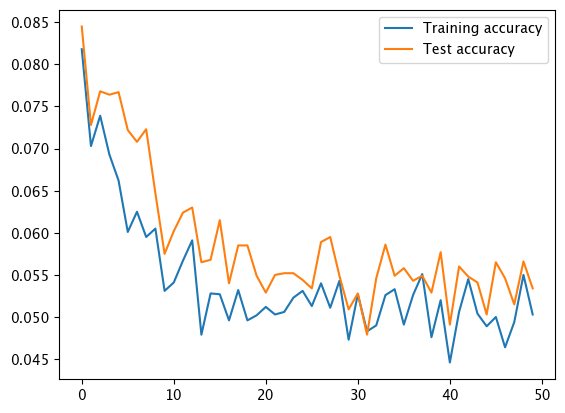

In [192]:
# accuracy
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Test accuracy')
plt.legend()
plt.show()



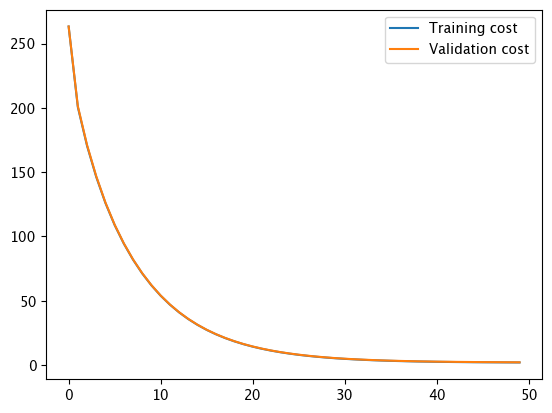

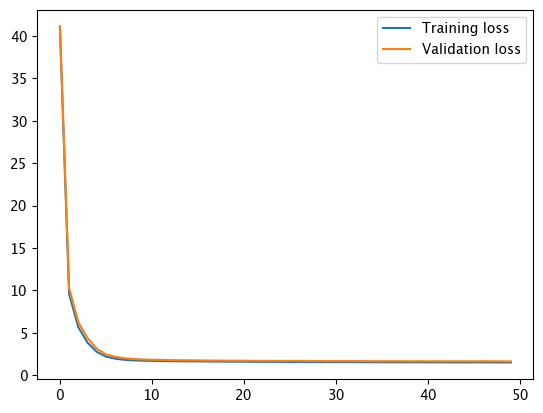

In [193]:
# plot cost and loss

plt.plot(train_cost, label='Training cost')
plt.plot(val_cost, label='Validation cost')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()